In [1]:
# Notebook 02
# Define momentum metrics (rolling / EWMA) and visualize

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)


In [2]:
data_path = "../data/raw/Wimbledon_featured_matches.csv"
df = pd.read_csv(data_path)

# 选定一场比赛（把这里换成你想看的 match_id）
match_id = "2023-wimbledon-1701"
df_match = df[df["match_id"] == match_id].copy()

# 按比赛顺序排序：盘 -> 局 -> 分
df_match = df_match.sort_values(
    by=["set_no", "game_no", "point_no"]
).reset_index(drop=True)

# point_result: player1赢=+1, player2赢=-1
df_match["point_result"] = np.where(df_match["point_victor"] == 1, 1, -1)

# 用于对照的累计分差
df_match["cumulative_score"] = df_match["point_result"].cumsum()

df_match.shape, df_match.head()


((334, 48),
               match_id         player1         player2 elapsed_time  set_no  game_no  point_no  p1_sets  p2_sets  \
 0  2023-wimbledon-1701  Carlos Alcaraz  Novak Djokovic     00:00:00       1        1         1        0        0   
 1  2023-wimbledon-1701  Carlos Alcaraz  Novak Djokovic     00:00:25       1        1         2        0        0   
 2  2023-wimbledon-1701  Carlos Alcaraz  Novak Djokovic     00:01:19       1        1         3        0        0   
 3  2023-wimbledon-1701  Carlos Alcaraz  Novak Djokovic     00:02:17       1        1         4        0        0   
 4  2023-wimbledon-1701  Carlos Alcaraz  Novak Djokovic     00:03:02       1        1         5        0        0   
 
    p1_games  p2_games p1_score p2_score  server  serve_no  point_victor  p1_points_won  p2_points_won  game_victor  \
 0         0         0        0        0       2         1             2              0              1            0   
 1         0         0        0       15      

In [3]:
window = 15  # 先选一个不大的窗口（之后可以调）
df_match["momentum_rm"] = (
    df_match["point_result"]
    .rolling(window=window, min_periods=1)
    .mean()
)

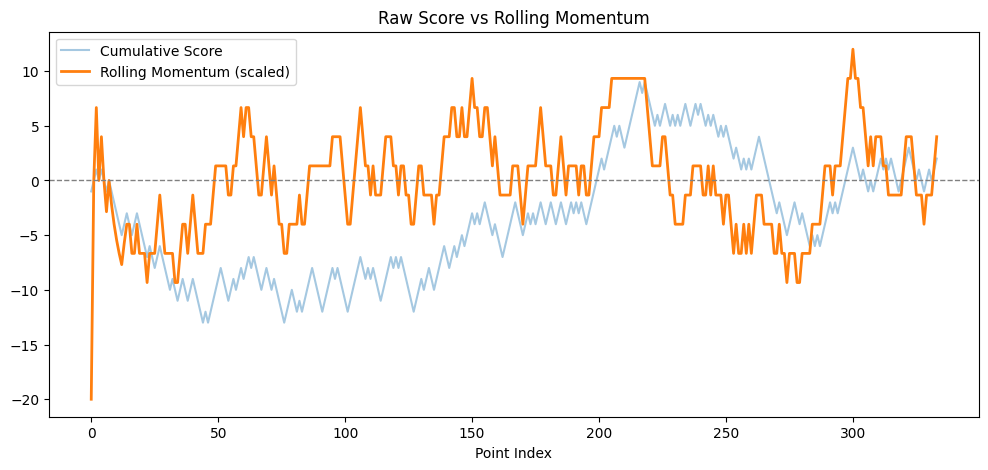

In [4]:
plt.figure(figsize=(12, 5))

plt.plot(df_match["cumulative_score"], label="Cumulative Score", alpha=0.4)
plt.plot(df_match["momentum_rm"] * 20, label="Rolling Momentum (scaled)", linewidth=2)

plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.legend()
plt.title("Raw Score vs Rolling Momentum")
plt.xlabel("Point Index")
plt.show()

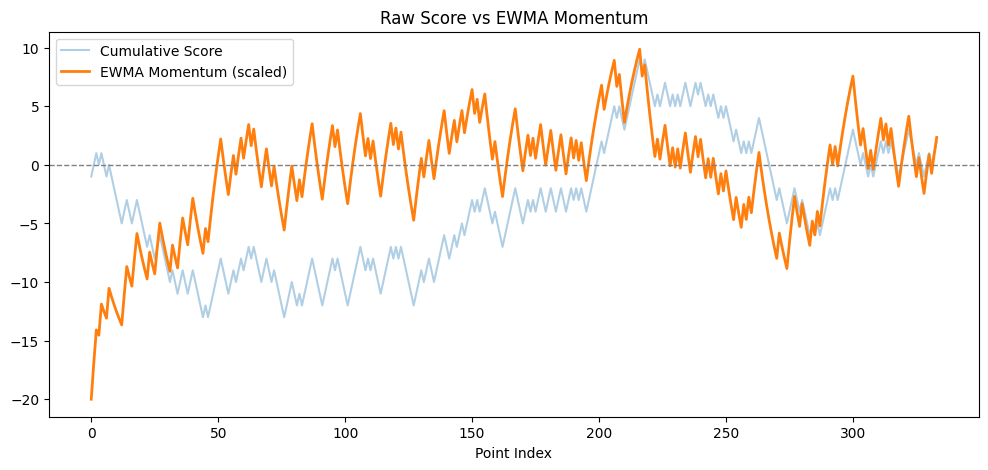

In [5]:
# EWMA momentum: 对最近得分更敏感
span = 25  # 类似“有效窗口”，可调参
df_match["momentum_ewm"] = df_match["point_result"].ewm(span=span, adjust=False).mean()

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(df_match["cumulative_score"], label="Cumulative Score", alpha=0.35)
plt.plot(df_match["momentum_ewm"] * 20, label="EWMA Momentum (scaled)", linewidth=2)
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.legend()
plt.title("Raw Score vs EWMA Momentum")
plt.xlabel("Point Index")
plt.show()


In [6]:
# server 列：1 表示 player1 发球，2 表示 player2 发球（题目数据示例也是这么解释的）
# point_victor：1/2 表示该分 winner（题目示例解释一致）
# 先估计：发球方赢这一分的经验概率
server_wins = (df_match["point_victor"] == df_match["server"]).astype(int)
p_server_win = server_wins.mean()
p_server_win


np.float64(0.6107784431137725)

In [7]:
# 发球方是否赢分
server_wins = (df_match["point_victor"] == df_match["server"]).astype(int)

# 发球方赢分概率（经验估计）
p_server_win = server_wins.mean()

# 发球校正的单分贡献（先在发球方视角）
df_match["serve_adj"] = np.where(server_wins == 1, 1 - p_server_win, -p_server_win)

# 转到 Player1 视角（正=对P1有利）
df_match["serve_adj_p1"] = np.where(df_match["server"] == 1, df_match["serve_adj"], -df_match["serve_adj"])

# EWMA 平滑
span2 = 25
df_match["momentum_srv_ewm"] = df_match["serve_adj_p1"].ewm(span=span2, adjust=False).mean()

p_server_win, df_match[["server","point_victor","serve_adj_p1","momentum_srv_ewm"]].head()

(np.float64(0.6107784431137725),
    server  point_victor  serve_adj_p1  momentum_srv_ewm
 0       2             2     -0.389222         -0.389222
 1       2             1      0.610778         -0.312298
 2       2             1      0.610778         -0.241293
 3       2             2     -0.389222         -0.252672
 4       2             1      0.610778         -0.186252)

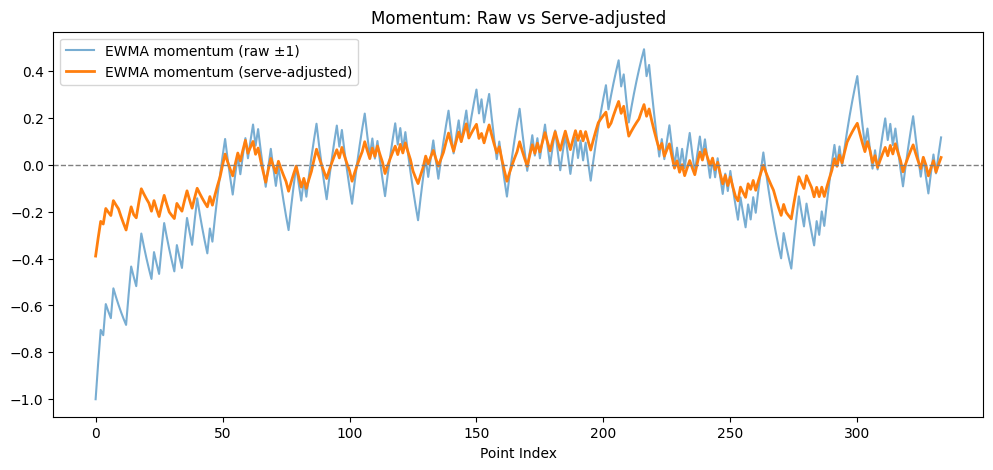

In [8]:
plt.figure(figsize=(12, 5))
plt.plot(df_match["momentum_ewm"], label="EWMA momentum (raw ±1)", alpha=0.6)
plt.plot(df_match["momentum_srv_ewm"], label="EWMA momentum (serve-adjusted)", linewidth=2)
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.legend()
plt.title("Momentum: Raw vs Serve-adjusted")
plt.xlabel("Point Index")
plt.show()

In [11]:
# ==========================================================
# 最终版：计算 swing points（势头转折点）
# 思路：
#   1) 先得到势头信号 m（建议用发球校正后的 momentum_srv_ewm）
#   2) 用“平滑后的斜率 trend”来判断趋势是否反转（上升→下降 or 下降→上升）
#      - 直接用 m.diff() 会很抖，所以对斜率再做一次 EWMA 平滑
#   3) 只保留“幅度足够大”的反转（过滤小抖动）
#      - 阈值使用分位数 quantile，自适应不同比赛/不同势头尺度
#   4) 反转往往会持续几分形成“反转区间”，我们只保留区间里 |m| 最大的那个点
#      - 等价于：用一个代表点描述该次 swing
#   5) 可选：加冷却时间 cool，保证相邻 swing 至少间隔若干分，避免过密
# ==========================================================
# ---------- 0) 取势头曲线（你已经算过 momentum_srv_ewm 才能用） ----------
m = df_match["momentum_srv_ewm"].copy()

# ---------- 1) 计算“趋势”= 势头的一阶差分（斜率），并做 EWMA 平滑 ----------
# m.diff() 表示：本分势头 - 上一分势头（斜率/变化率）
# span 越小越敏感，越大越平滑。经验值：3~10
trend_span = 5
trend = m.diff().ewm(span=trend_span, adjust=False).mean()

# ---------- 2) 处理 trend 为 0 的情况：用前向填充保持趋势方向 ----------
# 原因：在某些点 trend 可能非常接近 0 或等于 0，导致反转判断“来回跳”
# 做法：把 0 当成缺失，用上一时刻的趋势方向延续
trend2 = trend.copy()
trend2 = trend2.replace(0, np.nan).ffill()

# ---------- 3) 反转检测：趋势由正转负（峰）或由负转正（谷） ----------
# 峰：trend2(t-1) > 0 且 trend2(t) <= 0
# 谷：trend2(t-1) < 0 且 trend2(t) >= 0
rev = (
    ((trend2.shift(1) > 0) & (trend2 <= 0)) |
    ((trend2.shift(1) < 0) & (trend2 >= 0))
)

# ---------- 4) 幅度过滤：只保留“足够大”的 swing ----------
# amp_thr 用 |m| 的分位数做阈值：
#   - 0.80 会抓更多 swing（更敏感）
#   - 0.90/0.95 会更严格（只抓大 swing）
amp_q = 0.80
amp_thr = m.abs().quantile(amp_q)

# 候选 swing：反转 & 幅度大
candidate = rev & (m.abs() > amp_thr)

# 先把候选标出来（后面还要做“区间压缩”和“冷却”）
df_match["swing_flag"] = candidate.astype(int)

# ---------- 5) 区间压缩：连续若干分都满足 candidate，只保留 |m| 最大的那一分 ----------
# 解释：反转往往不是单点完成，而是一个过程（连续几分趋势来回切）
# 我们把连续 candidate 视为一次 swing 事件，然后选一个“最代表”的点（|m| 最大）
idx = df_match.index[df_match["swing_flag"] == 1].to_list()

keep = []
i = 0
while i < len(idx):
    j = i
    group = [idx[i]]
    # 把连续的索引收集成一个 group
    while j + 1 < len(idx) and idx[j + 1] == idx[j] + 1:
        j += 1
        group.append(idx[j])
    # 在这个反转区间里，只留 |m| 最大的点作为代表点
    best = max(group, key=lambda x: abs(m.loc[x]))
    keep.append(best)
    i = j + 1

# 先清空，再只标记代表点
df_match["swing_flag"] = 0
df_match.loc[keep, "swing_flag"] = 1

# ---------- 6) 可选：冷却时间（避免 swing 点过密） ----------
# 解释：如果比赛中噪声较大，可能出现两个 swing 点相隔很近
# 冷却时间 cool 表示：相邻 swing 至少隔 cool 分
# - 想更稀疏：cool=15~25
# - 想更密集：cool=5~10
cool = 15

final_idx = df_match.index[df_match["swing_flag"] == 1].to_list()
final_keep = []
last = -10**9

for x in final_idx:
    if x - last >= cool:
        final_keep.append(x)
        last = x
    else:
        # 如果太近：保留两者中 |m| 更大的那一个（更“重要”的 swing）
        # 这样不会因为冷却直接把大 swing 删掉
        if abs(m.loc[x]) > abs(m.loc[last]):
            final_keep[-1] = x
            last = x

df_match["swing_flag"] = 0
df_match.loc[final_keep, "swing_flag"] = 1

# ---------- 7) 输出检查 ----------
print("amp_thr =", float(amp_thr), " (quantile =", amp_q, ")")
print("swing_count =", int(df_match["swing_flag"].sum()))
df_match.loc[df_match["swing_flag"] == 1, ["set_no", "game_no", "point_no"]].head(10)


amp_thr = 0.15325741874831078  (quantile = 0.8 )
swing_count = 4


,set_no,game_no,point_no
13,1,2,14
34,1,5,35
208,3,7,209
275,5,1,276


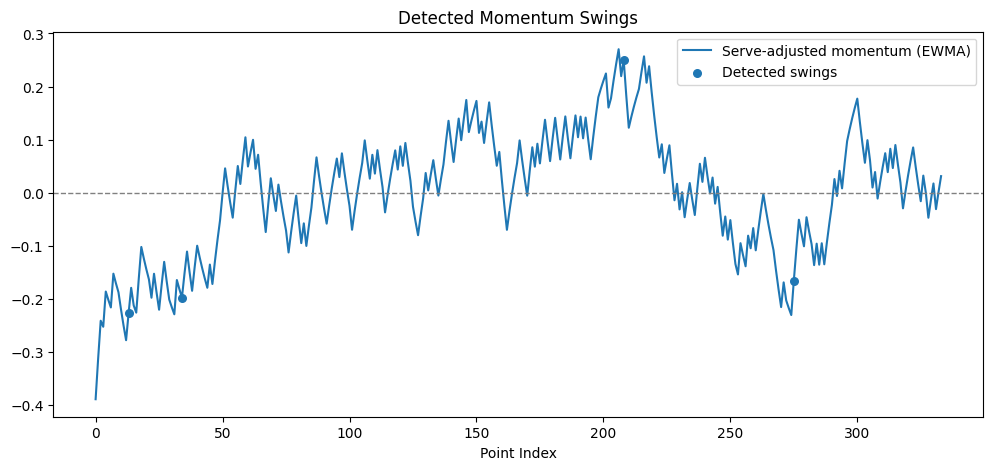

In [12]:
plt.figure(figsize=(12, 5))
plt.plot(m, label="Serve-adjusted momentum (EWMA)")
swing_idx = df_match.index[df_match["swing_flag"]==1]
plt.scatter(swing_idx, m.loc[swing_idx], s=30, label="Detected swings")
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.legend()
plt.title("Detected Momentum Swings")
plt.xlabel("Point Index")
plt.show()
